# Plot audio voltage

This notebook plots the voltage of a badge based on the voltage stored in an audio samples file. Can be used for measuring badge battery usage and total run time.

In [1]:
from __future__ import absolute_import, division, print_function

import os
import sys
import datetime
import pytz
import dateutil

import pandas as pd
import numpy as np

from ggplot import *
import gzip

%matplotlib inline

# Import the data analysis tools
import openbadge_analysis as ob
import openbadge_analysis.core

/home/orenled/anaconda2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/orenled/anaconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/orenled/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
eastern = pytz.timezone('US/Eastern')
utc  = pytz.timezone('UTC')

filename = '../data/hub_data/audio_archive.txt.gz'
with gzip.open(filename, 'r') as f:
    audio_chunks = ob.core.load_audio_chunks_as_json_objects(f, log_version='2.0')

In [3]:
# load data into a data frame
df = pd.DataFrame(audio_chunks,columns=['badge_address','timestamp','voltage','num_samples'])
print(df.head())

       badge_address     timestamp  voltage  num_samples
0  E0:B2:01:E3:09:8C  1.498859e+09    3.143            2
1  D8:59:E3:35:BD:C4  1.498859e+09    3.146            2
2  E0:B2:01:E3:09:8C  1.498859e+09    3.143          114
3  E0:B2:01:E3:09:8C  1.498859e+09    3.143          114
4  E0:B2:01:E3:09:8C  1.498859e+09    3.154           33


## Sainty check

In [4]:
# min/max values
df_group_by_badge = df.reset_index().groupby('badge_address')
print("Max:\n",df_group_by_badge.max(),"\n")
print("Min:\n",df_group_by_badge.min())

Max:
                     index     timestamp  voltage  num_samples
badge_address                                                
D8:59:E3:35:BD:C4  282459  1.499425e+09    3.172          114
E0:B2:01:E3:09:8C  279727  1.499417e+09    3.166          114 

Min:
                    index     timestamp  voltage  num_samples
badge_address                                               
D8:59:E3:35:BD:C4      1  1.498859e+09    1.765            0
E0:B2:01:E3:09:8C      0  1.498859e+09    1.754            0


In [5]:
# Nans?
print(len(df))
print(df[np.isnan(df['voltage'])])
print(df[np.isnan(df['timestamp'])])
print(df[df['badge_address'].isnull()])

282460
Empty DataFrame
Columns: [badge_address, timestamp, voltage, num_samples]
Index: []
Empty DataFrame
Columns: [badge_address, timestamp, voltage, num_samples]
Index: []
Empty DataFrame
Columns: [badge_address, timestamp, voltage, num_samples]
Index: []


## Timezone and resampling
Here, we convert the dates to timezone-aware format and then resample to 5 second intervals to make it easier to plot

In [6]:
# Converting timestamp (epoch) to UTC datetime
df['datetime'] = pd.to_datetime(df['timestamp'],unit='s', utc=True)

# Setting datetime as index so I can convert the timezone
df.sort_values('datetime')
df.index = pd.to_datetime(df.pop('datetime'), utc=True)
df = df.tz_localize(utc)
df = df.tz_convert(eastern)

# make it a column again
df = df.reset_index() 
print(df['datetime'].dtype)

# set index
df.set_index(['badge_address','datetime'], inplace=True, drop=True)

# Sort
df.sort_index(inplace=True)
print(df.head())

datetime64[ns, US/Eastern]
                                                       timestamp  voltage  \
badge_address     datetime                                                  
D8:59:E3:35:BD:C4 2017-06-30 17:43:01.845000-04:00  1.498859e+09    3.146   
                  2017-06-30 17:43:01.845000-04:00  1.498859e+09    3.146   
                  2017-06-30 17:43:07.545000-04:00  1.498859e+09    3.146   
                  2017-06-30 17:43:13.242000-04:00  1.498859e+09    3.158   
                  2017-06-30 17:43:13.242000-04:00  1.498859e+09    3.158   

                                                    num_samples  
badge_address     datetime                                       
D8:59:E3:35:BD:C4 2017-06-30 17:43:01.845000-04:00            2  
                  2017-06-30 17:43:01.845000-04:00          114  
                  2017-06-30 17:43:07.545000-04:00          114  
                  2017-06-30 17:43:13.242000-04:00           34  
                  2017-06-30 17:43:13

In [7]:
# http://pandas.pydata.org/pandas-docs/stable/cookbook.html
# http://pandas.pydata.org/pandas-docs/stable/timeseries.html#aggregation
# reample doesn't like multi index
df_by_datetime = df.reset_index('badge_address', drop=False)


df_grouped = df_by_datetime.groupby('badge_address')
print("df_grouped\n",df_grouped)
print(df_grouped.size(),"\n\n")

df_resampled = df_grouped.resample('5S').agg({'voltage': np.mean, 'num_samples': np.max})
print("df_resampled:\n",df_resampled.head(),"\n\n")

df_flat = df_resampled.reset_index()
print("df_flat:\n",df_flat.head(),"\n\n")

df_grouped
badge_address
D8:59:E3:35:BD:C4    142527
E0:B2:01:E3:09:8C    139933
dtype: int64 


df_resampled:
                                              voltage  num_samples
badge_address     datetime                                       
D8:59:E3:35:BD:C4 2017-06-30 17:43:00-04:00    3.146        114.0
                  2017-06-30 17:43:05-04:00    3.146        114.0
                  2017-06-30 17:43:10-04:00    3.158        114.0
                  2017-06-30 17:43:15-04:00    3.158        114.0
                  2017-06-30 17:43:20-04:00    3.166        114.0 


df_flat:
        badge_address                  datetime  voltage  num_samples
0  D8:59:E3:35:BD:C4 2017-06-30 17:43:00-04:00    3.146        114.0
1  D8:59:E3:35:BD:C4 2017-06-30 17:43:05-04:00    3.146        114.0
2  D8:59:E3:35:BD:C4 2017-06-30 17:43:10-04:00    3.158        114.0
3  D8:59:E3:35:BD:C4 2017-06-30 17:43:15-04:00    3.158        114.0
4  D8:59:E3:35:BD:C4 2017-06-30 17:43:20-04:00    3.166        114.0

In [8]:
# If needed, filter the data
#a=pd.Timestamp('2017-09-26 00:00')
#a=a.tz_localize(eastern)
#df_flat=df_flat[df_flat.datetime<a]

## Plot absolute time
by plotting the voltage, once can estimate how long the badge battery will late. You can expect to see the voltage sharpy drops after it reaches 2.5 volts. 
Also, if you look at the number of samples, you'll see that around 2.4 volts the badge starts loosing data since peaks in power draw will cause it to reset.

In [9]:
# for ggplot, you need to use dateutil timezones
tz_dateutil_est = dateutil.tz.gettz('US/Eastern')

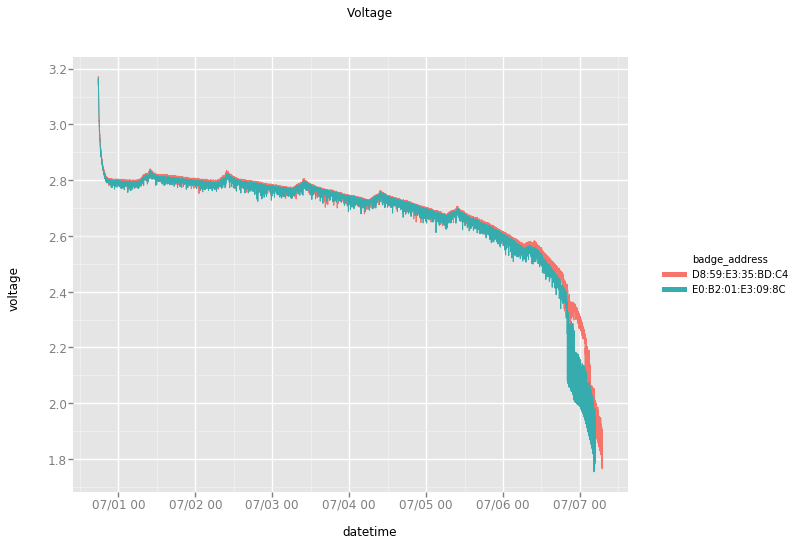

<ggplot: (8768554149505)>

In [10]:
ggplot(aes(x='datetime', y='voltage', color='badge_address'), data=df_flat) +\
    geom_line()+\
    scale_x_date(labels = date_format("%m/%d %H", tz = tz_dateutil_est)) +\
    ggtitle("Voltage")

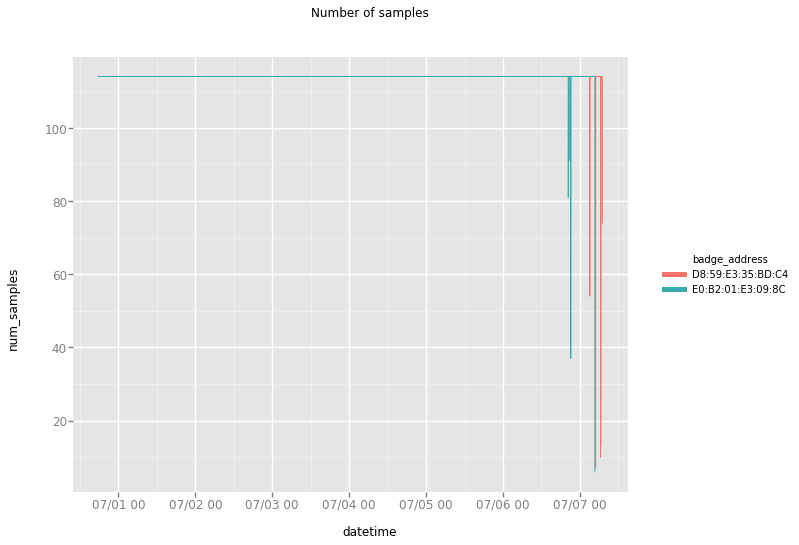

<ggplot: (8768553939741)>

In [11]:
ggplot(aes(x='datetime', y='num_samples', color='badge_address'), data=df_flat) +\
    geom_line() +\
    scale_x_date(labels = date_format("%m/%d %H", tz = tz_dateutil_est)) +\
    ggtitle("Number of samples")

## Plot with realtive time

In [12]:
first_data = df_flat.groupby('badge_address').first().rename(columns={'datetime':'first_datetime'})
first_data.reset_index(inplace=True)
del first_data['voltage']
del first_data['num_samples']
first_data

,badge_address,first_datetime
0,D8:59:E3:35:BD:C4,2017-06-30 17:43:00-04:00
1,E0:B2:01:E3:09:8C,2017-06-30 17:42:55-04:00


In [13]:
df_flat_realtive_time = pd.merge(df_flat, first_data, how='left',on='badge_address')
df_flat_realtive_time['relative'] = df_flat_realtive_time['datetime'] - df_flat_realtive_time['first_datetime']
df_flat_realtive_time['relative_days'] = df_flat_realtive_time['relative']/pd.Timedelta(days=1)

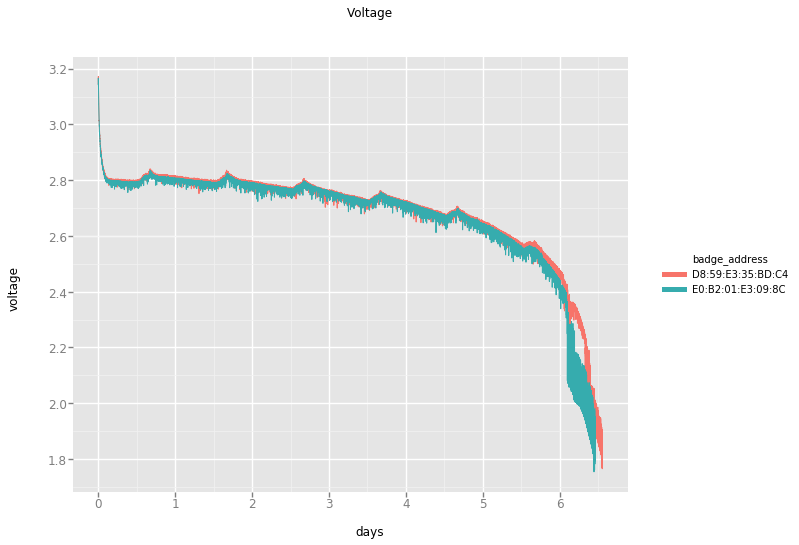

<ggplot: (8768553868449)>

In [14]:
ggplot(aes(x='relative_days', y='voltage', color='badge_address'), data=df_flat_realtive_time) +\
    geom_line() +\
    xlab("days") +\
    ggtitle("Voltage")

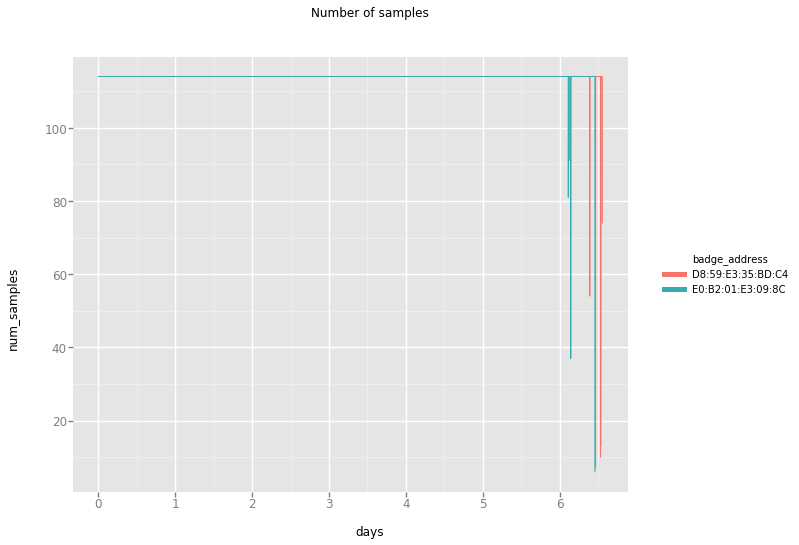

<ggplot: (8768553609229)>

In [15]:
ggplot(aes(x='relative_days', y='num_samples', color='badge_address'), data=df_flat_realtive_time) +\
    geom_line() +\
    xlab("days") +\
    ggtitle("Number of samples")